#### Basic Ranking based Recommenders

In [21]:
import os
import pprint
import tempfile
import json

from typing import Dict, Text
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import warnings
warnings.filterwarnings("ignore")

In [2]:
positive_samples = pd.read_csv('adj_matrx_v2/01_adjacency_continent_lang_study_subject_weighted_suppliers_average_profit.csv')
suppliers = positive_samples.suppliers_info.values.tolist()
positive_samples = positive_samples.set_index('suppliers_info')
positive_samples = positive_samples.sort_index()
positive_samples = positive_samples.stack().reset_index()

positive_samples.columns = ['suppliers__ref', 'projects__study_types_subject_ids', 'positive_score']

positive_samples['suppliers__ref'] = positive_samples['suppliers__ref'].astype('str')
positive_samples['positive_score'] = positive_samples['positive_score'].astype('float32')
positive_samples = positive_samples[positive_samples.positive_score != 0.0]
positive_samples
# test = pd.pivot(positive_samples, index=['suppliers__ref'], columns='projects__study_types_subject_ids', values='positive_score')

,suppliers__ref,projects__study_types_subject_ids,positive_score
10,africa@ara@271,b2b@other,1.288021
78,africa@eng@124,consumer_study@finance_legal_insurance,0.292984
95,africa@eng@124,consumer_study@travel,0.292984
133,africa@eng@271,consumer_study@finance_legal_insurance,0.477862
139,africa@eng@271,consumer_study@other,0.965878
...,...,...,...
36157,south-america@spa@537,consumer_study@entertainment,1.125698
36164,south-america@spa@537,consumer_study@other,1.148922
36170,south-america@spa@537,consumer_study@shopping_ecommerce,0.073925
36212,south-america@spa@601,consumer_study@entertainment,1.960784


In [23]:
unique_suppliers_subjects_lookup = {'unique_suppliers' : positive_samples.suppliers__ref.unique().tolist(), 'unique_subjects':positive_samples.projects__study_types_subject_ids.unique().tolist()}

json_obj = json.dumps(unique_suppliers_subjects_lookup, indent=4)

with open('utils_v2/continent_lang_study_sub_unique_suppliers_subjects_lookup.json', 'w') as f:
    f.write(json_obj)

#### 1. Preparing The Dataset

In [3]:
# features = ['region_cntry_lang_supplier', 'projects__study_types_subject_ids']
# target = []

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(positive_samples['suppliers__ref'].values, tf.string),
            tf.cast(positive_samples['projects__study_types_subject_ids'].values, tf.string),
            tf.cast(positive_samples['positive_score'].values, tf.float32)
        )
    )
)

ratings = training_dataset.map(lambda x,y,z: {
    "subject_id": y,
    "supplier_id": x,
    "score": z,
})

subjects = ratings.map(lambda x:x['subject_id'])

unique_subjects = positive_samples['projects__study_types_subject_ids'].unique()
unique_suppliers = positive_samples['suppliers__ref'].unique()

In [4]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

##### 2. Implementing a model

In [5]:
class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()
    embedding_dimension = 64

    # Compute embeddings for users.
    self.supplier_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_suppliers, mask_token=None),
      tf.keras.layers.Embedding(len(unique_suppliers) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.subject_embeddings = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
        vocabulary=unique_subjects, mask_token=None),
      tf.keras.layers.Embedding(len(unique_subjects) + 1, embedding_dimension)
    ])

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
      # Learn multiple dense layers.
      tf.keras.layers.Dense(256, activation="relu"),
      tf.keras.layers.Dense(64, activation="leaky_relu"),
      tf.keras.layers.Dense(32, activation="leaky_relu"),
      tf.keras.layers.Dense(16, activation="relu"),
      # Make rating predictions in the final layer.
      tf.keras.layers.Dense(1)
  ])

  def call(self, inputs):

    supplier_id, subject_id = inputs

    supplier_embedding = self.supplier_embeddings(supplier_id)
    subject_embedding = self.subject_embeddings(subject_id)

    return self.ratings(tf.concat([supplier_embedding, subject_embedding], axis=1))

In [6]:
class SupplierRecommender(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
      loss = tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model(
        (features["supplier_id"], features["subject_id"]))

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    labels = features.pop("score")

    rating_predictions = self(features)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)

In [7]:
cached_train = train.shuffle(100_000).batch(10).cache()
cached_test = test.batch(2).cache()

#### 3. Model Train

In [8]:
model = SupplierRecommender()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

callback = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', patience=50, restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint('models_2/final_model_weights/', \
    save_best_only=True, monitor='root_mean_squared_error', mode='min')

epoch=2000
history = model.fit(cached_train, epochs=epoch, callbacks=[callback, checkpoint])

244/244 [==============================] - 1s 3ms/step - root_mean_squared_error: 0.1282 - loss: 0.0163 - regularization_loss: 0.0000e+00 - total_loss: 0.0163
Epoch 65/2000
244/244 [==============================] - 1s 3ms/step - root_mean_squared_error: 0.1096 - loss: 0.0119 - regularization_loss: 0.0000e+00 - total_loss: 0.0119
Epoch 66/2000
244/244 [==============================] - 1s 3ms/step - root_mean_squared_error: 0.1257 - loss: 0.0157 - regularization_loss: 0.0000e+00 - total_loss: 0.0157
Epoch 67/2000
244/244 [==============================] - 1s 3ms/step - root_mean_squared_error: 0.1690 - loss: 0.0284 - regularization_loss: 0.0000e+00 - total_loss: 0.0284
Epoch 68/2000
244/244 [==============================] - 1s 3ms/step - root_mean_squared_error: 0.1774 - loss: 0.0313 - regularization_loss: 0.0000e+00 - total_loss: 0.0313
Epoch 69/2000
244/244 [==============================] - 1s 2ms/step - root_mean_squared_error: 0.1272 - loss: 0.0161 - regularization_loss: 0.0000e+

INFO:tensorflow:Assets written to: models_2/final_model_weights\assets


INFO:tensorflow:Assets written to: models_2/final_model_weights\assets


244/244 [==============================] - 2s 10ms/step - root_mean_squared_error: 0.0586 - loss: 0.0034 - regularization_loss: 0.0000e+00 - total_loss: 0.0034
Epoch 73/2000
240/244 [============================>.] - ETA: 0s - root_mean_squared_error: 0.0514 - loss: 0.0026 - regularization_loss: 0.0000e+00 - total_loss: 0.0026

INFO:tensorflow:Assets written to: models_2/final_model_weights\assets


INFO:tensorflow:Assets written to: models_2/final_model_weights\assets


244/244 [==============================] - 2s 9ms/step - root_mean_squared_error: 0.0512 - loss: 0.0026 - regularization_loss: 0.0000e+00 - total_loss: 0.0026
Epoch 74/2000
243/244 [============================>.] - ETA: 0s - root_mean_squared_error: 0.0499 - loss: 0.0025 - regularization_loss: 0.0000e+00 - total_loss: 0.0025

INFO:tensorflow:Assets written to: models_2/final_model_weights\assets


INFO:tensorflow:Assets written to: models_2/final_model_weights\assets


244/244 [==============================] - 2s 10ms/step - root_mean_squared_error: 0.0498 - loss: 0.0025 - regularization_loss: 0.0000e+00 - total_loss: 0.0025
Epoch 75/2000
236/244 [============================>.] - ETA: 0s - root_mean_squared_error: 0.0462 - loss: 0.0021 - regularization_loss: 0.0000e+00 - total_loss: 0.0021

INFO:tensorflow:Assets written to: models_2/final_model_weights\assets


INFO:tensorflow:Assets written to: models_2/final_model_weights\assets


244/244 [==============================] - 2s 9ms/step - root_mean_squared_error: 0.0457 - loss: 0.0021 - regularization_loss: 0.0000e+00 - total_loss: 0.0021
Epoch 76/2000
244/244 [==============================] - 0s 2ms/step - root_mean_squared_error: 0.0469 - loss: 0.0022 - regularization_loss: 0.0000e+00 - total_loss: 0.0022
Epoch 77/2000
244/244 [==============================] - 0s 2ms/step - root_mean_squared_error: 0.0505 - loss: 0.0025 - regularization_loss: 0.0000e+00 - total_loss: 0.0025
Epoch 78/2000
244/244 [==============================] - 0s 2ms/step - root_mean_squared_error: 0.0892 - loss: 0.0079 - regularization_loss: 0.0000e+00 - total_loss: 0.0079
Epoch 79/2000
244/244 [==============================] - 0s 2ms/step - root_mean_squared_error: 0.1473 - loss: 0.0216 - regularization_loss: 0.0000e+00 - total_loss: 0.0216
Epoch 80/2000
244/244 [==============================] - 0s 2ms/step - root_mean_squared_error: 0.1583 - loss: 0.0249 - regularization_loss: 0.0000e+

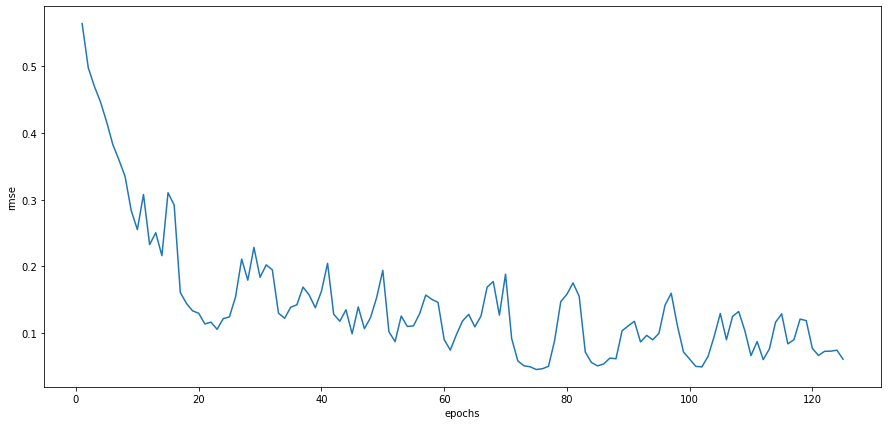

In [9]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,7)) 

plt.plot(list(range(1, len(history.history['root_mean_squared_error'])+1)), history.history['root_mean_squared_error'])
plt.xlabel("epochs")
plt.ylabel("rmse")
plt.show()

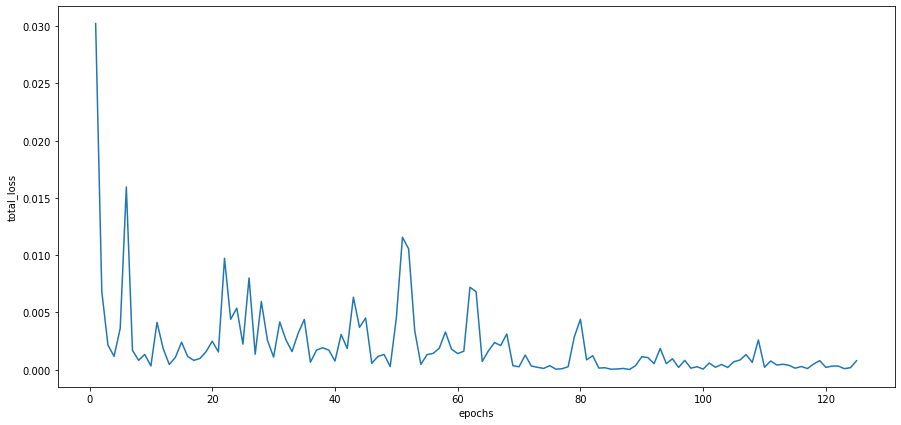

In [10]:
plt.figure(figsize=(15,7)) 
plt.plot(list(range(1, len(history.history['total_loss'])+1)), history.history['total_loss'])
plt.xlabel("epochs")
plt.ylabel("total_loss")
plt.show()

#### 4. Inference

In [11]:
# preds = []

# for i in positive_samples.itertuples():
#     preds.append(model({
#         "supplier_id": np.array([i[1]]),
#         "subject_id": np.array([i[2]])
#         }).numpy().tolist()[0][0])

#### 5. Save Weights

In [12]:
# import os

# if not os.path.exists('models_2/final_model_weights/'):
#     os.makedirs('models_2/final_model_weights/')
    
# model.save_weights('models_2/final_model_weights/')

#### 6. Load Weights

In [13]:
D = SupplierRecommender()
D.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
D.load_weights('models_2/final_model_weights/')

preds = []

for i in positive_samples.itertuples():
    preds.append(D({
        "supplier_id": np.array([i[1]]),
        "subject_id": np.array([i[2]])
        }).numpy().tolist()[0][0])

In [14]:
act_pred = pd.DataFrame([preds, positive_samples['positive_score'].values.tolist()]).T
act_pred.columns = ['preds', 'actual']

In [15]:
act_pred[act_pred.actual != 0.0]

,preds,actual
0,1.334971,1.288021
1,0.264755,0.292984
2,0.254784,0.292984
3,0.508455,0.477862
4,0.979096,0.965878
...,...,...
2428,1.120410,1.125698
2429,1.160680,1.148922
2430,0.063067,0.073925
2431,1.749063,1.960784


In [20]:
act_pred[act_pred.actual != 0.0][(act_pred.actual - act_pred.preds) > 1.0].shape

(2, 2)

In [17]:
min(history.history['root_mean_squared_error'])

0.045718442648649216